In [2]:
%matplotlib inline

import numpy as np

import matplotlib.image as mpimg

import matplotlib.pyplot as plt

import matplotlib.cm as cm

import png

import scipy.ndimage as ndimage

from scipy.misc import imsave, imshow

from scipy.ndimage import filters

import pyopencl as cl

In [3]:
# Our starting image
img = ndimage.imread('./eed-noise.png')
# extract red channel
img = img[:,:,0]
height, width = img.shape

# Image for inpainting
inpainting_img = ndimage.imread('./inpainting-input.png')
inpainting_mask = ndimage.imread('./inpainting-mask.png')
inpainting_mask = inpainting_mask[:,:,0]
inpaint_h, inpaint_w = inpainting_img.shape

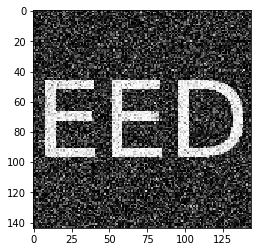

In [4]:
imgplot = plt.imshow(img, cm.Greys_r, interpolation='none', vmin = 0, vmax = 255)

In [5]:
dx, dt = 1,0.25

edge_threshold = 5.0; lsq = edge_threshold**2

u = np.copy(img).astype(float)

d = np.zeros((height, width))

eps = np.finfo(float).eps # machine epsilon

In [6]:
def show(img, height=height, width=width):
    plt.imshow(img.reshape(height,width), cm.Greys_r, interpolation='none', vmin = 0, vmax = 255)

In [7]:
def do_step_reflected_boundary_linear_homogeneous(u):
        
    for i, u_x in np.ndenumerate(u):
        if i[0] - 1 < 0:
            left = u[(i[0]+1, i[1])]
        else:
            left = u[(i[0]-1, i[1])]
        if i[0] + 1 > u.shape[1]-1:
            right = u[(i[0]-1, i[1])]
        else:
            right = u[(i[0]+1, i[1])]
        if i[1] - 1 < 0:
            up = u[(i[0], i[1]+1)]
        else:
            up = u[(i[0], i[1]-1)]
        if i[1] + 1 > u.shape[0]-1:
            down = u[(i[0], i[1]-1)]
        else:
            down = u[(i[0], i[1]+1)]
        
        d[i] = up + down + left + right - (4 * u_x)
        d[i] *= dt
    u += d


In [8]:
def do_step_reflected_boundary_nonlinear_isotropic(u):
    pad_u = np.pad(u, 1, 'reflect')
    
    for i, u_i in np.ndenumerate(u):
        # translate to padded co-ordinates
        i0 = i[0]+1
        i1 = i[1]+1
        
        # get values of neighboring pixels for finite differences
        left      = pad_u[i0-1, i1]
        right     = pad_u[i0+1, i1]
        up        = pad_u[i0, i1-1]
        down      = pad_u[i0, i1+1]
        upleft    = pad_u[i0-1, i1-1]
        upright   = pad_u[i0+1, i1-1]
        downleft  = pad_u[i0-1, i1+1]
        downright = pad_u[i0+1, i1+1]

                       
        # approximate first derivatives at half-point between pixels
        d_left  = left  - u_i
        d_right = right - u_i
        d_up    = up    - u_i
        d_down  = down  - u_i
          
        # Perona-Malik diffusion tensor
        g = lambda grad: 1.0/(1.0 + (grad*grad)/lsq)
        g_left, g_right, g_up, g_down = map(g, [d_left, d_right, d_up, d_down])
        
        #d[i] = up + down + left + right - (4 * u_i)
        d[i] = g_left*d_left + g_right*d_right + g_up*d_up + g_down*d_down
        d[i] *= dt
    u += d


In [9]:
def gDerivative(order, x, Gs, scale):
    if order == 0:
        return Gs
    elif order == 1:
        return -x/(scale**2) * Gs
    elif order == 2:
        return (x**2-scale**2)/(scale**4) * Gs
    else:
        raise Exception('only derivatives up to second order are supported')

In [10]:
x = np.arange(-3,4)
Gs = np.exp( -x**2 / 2 )
Gs /= np.sum(Gs)
-x * Gs

array([ 0.01000732,  0.13400161,  0.18212707,  0.        , -0.18212707,
       -0.13400161, -0.01000732])

In [11]:
def gaussian_derivative(u, scale, ox, oy):
    scale = float(scale)
    #calculate sample points
    K = np.ceil(3*scale)
    x = np.arange(-K, K+1) # -K, -K+1, ..., 0, ..., K-1, K
    
    #sample gaussian and normalize (zero-order 1D kernel)
    Gs = np.exp( -x**2 / (2*scale**2) )
    Gs = Gs / np.sum(Gs)
    #calculate the derivatives in x and y direction
    Gsx = gDerivative( ox, x, Gs, scale)
    Gsy = gDerivative( oy, x, Gs, scale)
    # up until now everything can be precomputed
    #do the convolutions
    tmp = filters.convolve1d(u, Gsx, axis=1)
    return filters.convolve1d(tmp, Gsy, axis=0)

In [12]:
def do_step_eed(u):
    # based on https://staff.fnwi.uva.nl/r.vandenboomgaard/nldiffusionweb/nldiffusioncode.pdf
    pad_u = np.pad(u, 1, 'reflect')
    
    # gaussian derivatives
    #Rx = filters.gaussian_filter1d(u, sigma=1, axis=0, order=1)
    #Ry = filters.gaussian_filter1d(u, sigma=1, axis=1, order=1)
    # Rx = convolute order 1 along x axis, then order 0 along y
    # Ry = convolute order 0 along x axis, then order 1 along y
    Rx = gaussian_derivative(u, 1.0, 1, 0)
    Ry = gaussian_derivative(u, 1.0, 0, 1)
    #everything below this line for computing the diffusivity tensor is per-pixel (no dependency on neighbors)
    # these are all element-wise operations
    Rx2 = Rx*Rx
    Ry2 = Ry*Ry
    Rw2 = Rx2+Ry2
    Rw = np.sqrt(Rw2)
    
    # eigenvalues for diffusion tensor
    c2 = 1.0/(1.0 + (Rw / edge_threshold)**2) # Perona-Malik diffusivity across edges
    c1 = 1                     # full diffusion along edges
    
    #c2 = np.exp(-1.0 * (Rw / edge_threshold)**2)
    #c1 = 0.2 * c2
    
    # diffusion tensor components
    a = (c1*Rx2 + c2*Ry2) / (Rw2 + eps)
    b = (c2 - c1) * Rx * Ry / (Rw2 + eps)
    c = (c1*Ry2 + c2*Rx2) / (Rw2 + eps)
    
    a = np.pad(a, 1, 'reflect')
    b = np.pad(b, 1, 'reflect')
    c = np.pad(c, 1, 'reflect')
    pad_u = np.pad(u, 1, 'reflect')
    
    #todo: implement this using translation and numpy parallel math
    for i, u_i in np.ndenumerate(u):
        # translate to padded co-ordinates
        i0 = i[0]+1
        i1 = i[1]+1
        
        # get values of neighboring pixels for finite differences
        # notation: first character is variable name. second character
        # is p if x-coord is Plus 1, m for Minus 1. Same for third
        # character but with y-coord. c if no plus or minus for Center.
        umc = pad_u[i0-1, i1]
        upc = pad_u[i0+1, i1]
        ucm = pad_u[i0  , i1-1]
        ucp = pad_u[i0  , i1+1]
        umm = pad_u[i0-1, i1-1]
        upm = pad_u[i0+1, i1-1]
        ump = pad_u[i0-1, i1+1]
        upp = pad_u[i0+1, i1+1]
        ucc = u_i
        
        # Get neighboring diffusion tensor components to use in approximation
        amc = a[i0-1, i1]
        apc = a[i0+1, i1]
        acc = a[i0  , i1]
        
        bmc = b[i0-1, i1]
        bpc = b[i0+1, i1]
        bcm = b[i0  , i1-1]
        bcp = b[i0  , i1+1]
        bcc = b[i0  , i1]
        
        ccp = c[i0, i1+1]
        ccm = c[i0, i1-1]
        ccc = c[i0, i1]
        
        # stencil method for derivative wrt time
        # todo: read up on stencil methods
        
        d[i] = (
            -0.25 * (bmc+bcp) * ump +
             0.5  * (ccp+ccc) * ucp +
             0.25 * (bpc+bcp) * upp +
             0.5  * (amc+acc) * umc -
             0.5  * (amc+2*acc+apc+ccm+2*ccc+ccp) * ucc +
             0.5  * (apc+acc) * upc +
             0.25 * (bmc+bcm) * umm +
             0.5  * (ccm+ccc) * ucm -
             0.25 * (bpc+bcm) * upm
        )
        d[i] *= dt
    u += d


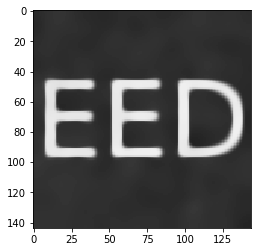

In [13]:
u = np.copy(img).astype(float)
#u = ndimage.gaussian_filter(u, sigma=1)
for i in xrange(int(1/dt)*20): do_step_eed(u)
show(u)

In [278]:
imsave('/tmp/eed_t20.png', u)

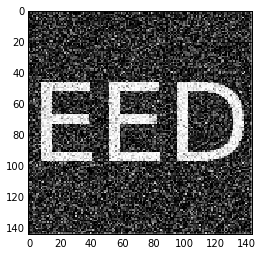

In [228]:
show(u) # Before

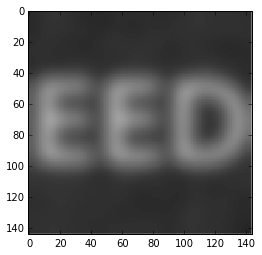

In [189]:
show(u) # After

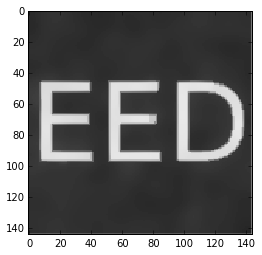

In [287]:
u = np.copy(img).astype(float)
u = ndimage.gaussian_filter(u, sigma=1)
for i in xrange(int(1/dt)*20): do_step_reflected_boundary_nonlinear_isotropic(u)
show(u)

In [188]:
for i in xrange(10*20): do_step_reflected_boundary_linear_homogeneous(u)

In [129]:
np.max(u)

253.64919238916195

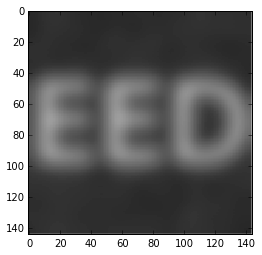

In [190]:
with_blur = ndimage.gaussian_filter(img, sigma=np.sqrt(2*20)); show(with_blur)

In [140]:
((with_blur - u) ** 2).mean(axis=None)

15.146947291544514

In [161]:
A = np.array([1,2,3,4,5,6,7,8,9]).reshape((3,3))
A = np.pad(A, 1, 'reflect')

A[0,2]

5

In [159]:
A

array([[5, 4, 5, 6, 5],
       [2, 1, 2, 3, 2],
       [5, 4, 5, 6, 5],
       [8, 7, 8, 9, 8],
       [5, 4, 5, 6, 5]])

In [224]:
x1 = np.arange(9.0).reshape((3,3)); x1
np.dot(x1, x1)
x1**2

array([[  0.,   1.,   4.],
       [  9.,  16.,  25.],
       [ 36.,  49.,  64.]])

In [208]:
x1

array([[ 0.,  1.,  2.],
       [ 3.,  4.,  5.],
       [ 6.,  7.,  8.]])

In [242]:
np.arange(-3, 3+1
    )

array([-3, -2, -1,  0,  1,  2,  3])

In [304]:
a = np.float32(255.0)
b = np.float32(0.00255)
ratio_of_squares = a**2/b**2
square_of_ratio = (a/b)**2
print "a**2/b**2", repr(ratio_of_squares), "(a/b)**2", repr(square_of_ratio)
print "error", abs(square_of_ratio - ratio_of_squares)
print "a**2", repr(a**2), "b**2", repr(b**2)

a**2/b**2 9999999278.316349 (a/b)**2 10000000000.0
error 721.68365097
a**2 65025.0 b**2 6.5025004692748274e-06


In [306]:
(-1)%25

24

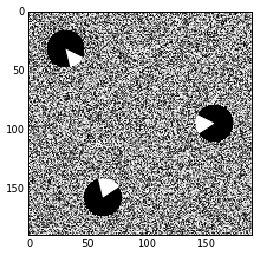

In [42]:
show(inpainting_img, inpaint_h, inpaint_w)


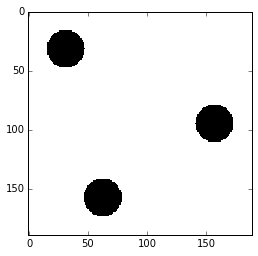

In [38]:
show(inpainting_mask, inpaint_h, inpaint_w)

In [96]:
def do_step_eed_inpainting(u, mask, d):
    # based on https://staff.fnwi.uva.nl/r.vandenboomgaard/nldiffusionweb/nldiffusioncode.pdf
    edge_threshold = 0.01
    sigma = 4.0
    
    # gaussian derivatives
    #Rx = filters.gaussian_filter1d(u, sigma=1, axis=0, order=1)
    #Ry = filters.gaussian_filter1d(u, sigma=1, axis=1, order=1)
    Rx = gaussian_derivative(u, sigma, 1, 0)
    Ry = gaussian_derivative(u, sigma, 0, 1)
    Rx2 = Rx*Rx
    Ry2 = Ry*Ry
    Rw2 = Rx2+Ry2
    Rw = np.sqrt(Rw2)
    
    # eigenvalues for diffusion tensor
    c2 = 1.0/((1.0 + (Rw / edge_threshold)**2)**0.5) # charbonnier diffusivity across edges
    c1 = 1                                    # full diffusion along edges
    
    #c2 = np.exp(-1.0 * (Rw / edge_threshold)**2)
    #c1 = 0.2 * c2
    
    # diffusion tensor components
    a = (c1*Rx2 + c2*Ry2) / (Rw2 + eps)
    b = (c2 - c1) * Rx * Ry / (Rw2 + eps)
    c = (c1*Ry2 + c2*Rx2) / (Rw2 + eps)
    
    a = np.pad(a, 1, 'reflect')
    b = np.pad(b, 1, 'reflect')
    c = np.pad(c, 1, 'reflect')
    pad_u = np.pad(u, 1, 'reflect')
    pad_mask = np.pad(mask, 1, 'reflect')
    
    #todo: implement this using translation and numpy parallel math
    for i, mask_i in np.ndenumerate(mask):
        if mask_i == 0:
            d[i] = 0
            continue
        
        # translate to padded co-ordinates
        i0 = i[0]+1
        i1 = i[1]+1
        
        u_i = u[i]
        
        # get values of neighboring pixels for finite differences
        # notation: first character is variable name. second character
        # is p if x-coord is Plus 1, m for Minus 1. Same for third
        # character but with y-coord. c if no plus or minus for Center.
        umc = pad_u[i0-1, i1]
        upc = pad_u[i0+1, i1]
        ucm = pad_u[i0  , i1-1]
        ucp = pad_u[i0  , i1+1]
        umm = pad_u[i0-1, i1-1]
        upm = pad_u[i0+1, i1-1]
        ump = pad_u[i0-1, i1+1]
        upp = pad_u[i0+1, i1+1]
        ucc = u_i
        
        # Get neighboring diffusion tensor components to use in approximation
        amc = a[i0-1, i1]
        apc = a[i0+1, i1]
        acc = a[i0  , i1]
        
        bmc = b[i0-1, i1]
        bpc = b[i0+1, i1]
        bcm = b[i0  , i1-1]
        bcp = b[i0  , i1+1]
        bcc = b[i0  , i1]
        
        ccp = c[i0, i1+1]
        ccm = c[i0, i1-1]
        ccc = c[i0, i1]
        
        # stencil method for derivative wrt time
        # todo: read up on stencil methods
        
        d[i] = (
            -0.25 * (bmc+bcp) * ump +
             0.5  * (ccp+ccc) * ucp +
             0.25 * (bpc+bcp) * upp +
             0.5  * (amc+acc) * umc -
             0.5  * (amc+2*acc+apc+ccm+2*ccc+ccp) * ucc +
             0.5  * (apc+acc) * upc +
             0.25 * (bmc+bcm) * umm +
             0.5  * (ccm+ccc) * ucm -
             0.25 * (bpc+bcm) * upm
        )
        d[i] *= dt
    u += d


In [97]:
d_inpainting = np.zeros((inpaint_h, inpaint_w))

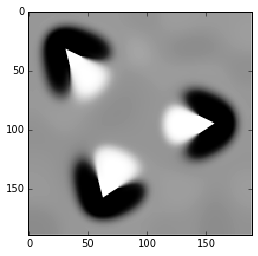

In [99]:
u = np.copy(inpainting_img).astype(float)
#u = ndimage.gaussian_filter(u, sigma=1)
for i in xrange(int(1/dt)*2000):
    do_step_eed_inpainting(u, inpainting_mask, d_inpainting)
    #if i % 10 == 0:
    #    imsave('/tmp/images/eed_inpainting_t%s.png' % i, u)
        
show(u, inpaint_w, inpaint_h)

In [73]:
d_inpainting.shape

(189, 189)

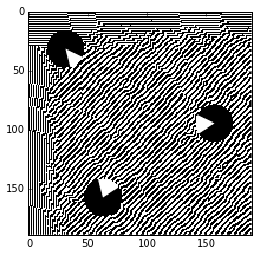

In [17]:
### Doing openCL stuff now

(144, 144)


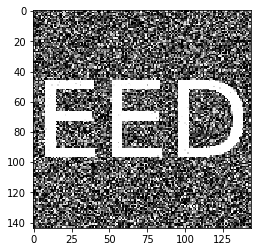

In [12]:
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

mf = cl.mem_flags

img_g = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=img.astype(np.float32))

# replace float with half and see what happens
prg = cl.Program(ctx, """
__kernel void timestwo(
    __global float *img_g)
{
  int gidx = get_global_id(0);
  int gidy = get_global_id(1);
  img_g[gidx + gidy*144] = 2 * img_g[gidx + gidy*144];
}
""").build()

prg.timestwo(queue, img.shape, None, img_g)

result_np = np.empty_like(img).astype(np.float32)
cl.enqueue_copy(queue, result_np, img_g)

# Show results
show(result_np)
print result_np.shape

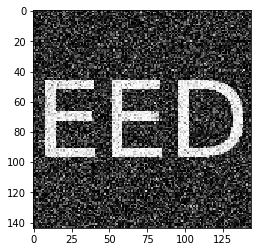

In [8]:
show(img)

In [57]:
result_np

array([[  1.38240000e+04,   5.88800000e+03,   7.42400000e+03, ...,
          7.93600000e+03,   1.40800000e+04,   1.76640000e+04],
       [  3.32800000e+03,   1.45920000e+04,   0.00000000e+00, ...,
          8.44800000e+03,   0.00000000e+00,   2.35520000e+04],
       [  8.70400000e+03,   1.79200000e+03,   6.40000000e+03, ...,
          1.58720000e+04,   1.25440000e+04,   3.32800000e+03],
       ..., 
       [  2.10000000e+01,   7.90000000e+01,   5.20000000e+01, ...,
          2.00000000e+00,   1.30000000e+01,   2.00000000e+00],
       [  0.00000000e+00,   2.80000000e+01,   5.70000000e+01, ...,
          2.70000000e+01,   0.00000000e+00,   5.80000000e+01],
       [  8.00000000e+00,   1.60000000e+01,   4.50000000e+01, ...,
          6.50000000e+01,   5.00000000e+01,   0.00000000e+00]])

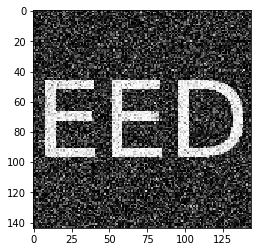

In [41]:
show(img)